### **Nota Bene**

That script is only for information.
It aims to show some works done in terms of FE to improve model but are not used because don't improve model at the end.

# Import libraries

### General libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.express as px
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings

warnings.filterwarnings("ignore")

### Pre proceesing libraries

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

### Modeling libraries

In [3]:
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import xgboost as xgb

from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import data

When we first tried to load the csv file into a dataframe, we got this error 
"ParserError: Error tokenizing data. C error: Expected 12 fields in line 3350, saw 13"

Meaning that at row 3350, there is an extra column. We modified the file trough excel where we've noticed that the columns were shifted to the right. The same for the rows 4704,5879 and 8981  

In [4]:
# import book dataset from the folder where you store it.
# change the link below accordinlgy
df=pd.read_csv("C:/Users/romai/Documents/DSTI/4-Python Labs/Project/Python/dataset/books_dataset.csv", index_col="bookID", on_bad_lines = 'error')

# Data Cleaning & Feature Engineering 

## Features

In [5]:
#Dropping useless columns: isbn and isbn13
df = df.drop(columns = ['isbn','isbn13'])

In [6]:
#Renaming '  num_pages' in order to remove the extra spaces and displaying columns names
df.rename(columns={'  num_pages':'num_pages'}, inplace=True)

In [7]:
#Change the format of column "publication_date" 
df['publication_date'] = pd.to_datetime(df['publication_date'], dayfirst = False, yearfirst = False, errors = 'coerce')

In [8]:
#correcting 2 NaT by correct date
df.loc[31373,"publication_date"]='10/30/2000'
df.loc[45531,"publication_date"] ='6/30/1982'
df.loc[[31373,45531]]

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,
31373,In Pursuit of the Proper Sinner (Inspector Lyn...,Elizabeth George,4.10,eng,718,10608,295,2000-10-30,Bantam Books
45531,Montaillou village occitan de 1294 à 1324,Emmanuel Le Roy Ladurie/Emmanuel Le Roy-Ladurie,3.96,fre,640,15,2,1982-06-30,Folio histoire


In [9]:
# Splitting date column into month and year columns - move in FE
df['publication_month'] = df['publication_date'].dt.month
df['publication_year'] = df['publication_date'].dt.year

### Language grouping

In [10]:
#step 1: group en-us, en-GB and en-CA under 1 language code (eng)
df.language_code = df.language_code.replace({'en-US':'eng', 'en-GB':'eng', 'en-CA':'eng'})

#step 2: groups of language: english (eng) vs other
df['language_code'] = np.where(df['language_code'] != 'eng', 'other', 'eng')

### Authors

In [11]:
# create 2 new columns related to author in order to simplify features:
# number_of_authors: single author vs multiple authors -> Single/Multiple -> boolean
df['number_of_authors']=np.where(df['authors'].str.split(pat="/").str.len()==1, "single", "multiple")

#primary_authror: keep 1st author in case of multiple authors
df['primary_author']=df['authors'].str.split(pat="/").str[0]

In [12]:
df.groupby(["number_of_authors"]).describe().average_rating

,count,mean,std,min,25%,50%,75%,max
number_of_authors,,,,,,,,
multiple,4564.0,3.964963,0.357029,0.0,3.8075,3.99,4.17,5.0
single,6563.0,3.911842,0.347588,0.0,3.7500,3.94,4.11,5.0


A bit more books with multiple authors but average_rating quite similar
***

How many books per author? Can we create a new feature (author_total_book)

In [13]:
author=df.groupby('primary_author').agg({'average_rating':['count','mean'], 'num_pages':['mean']})
author.columns = [" ".join(x) for x in author.columns.ravel()]
author

,average_rating count,average_rating mean,num_pages mean
primary_author,,,
A.B. Yehoshua,2,3.600000,416.000000
A.D.P. Briggs,1,3.760000,256.000000
A.E. Cunningham,1,4.150000,232.000000
A.J. Jacobs,1,3.760000,389.000000
A.M. Homes,1,3.280000,256.000000
...,...,...,...
Zoë Heller,2,3.710000,251.000000
bell hooks,6,4.230000,188.000000
Åsne Seierstad,3,3.763333,291.333333


In [14]:
author_dict=df.groupby('primary_author').average_rating.count().to_dict()

for author in author_dict.keys():
    author_index = df.loc[(df.primary_author == author),:].index
    df.loc[author_index,"author_total_book"] = author_dict[author]

### Title

Let's create a new feature: title_len (= length of the title)

In [15]:
df['title_len']=df['title'].str.len()

## Target variable

### Average rating categorization

In [16]:
# create 3 categories Low < 3, Mid between 3 and 4 (excl) and high above 4 (5.001 to include the rating = 5)
bins = [ 0,3, 4, 5.001]
label = [0, 1, 2]
df['cat_rating'] = pd.cut(df['average_rating'], bins, labels=label, right = False)

In [17]:
df.groupby(["cat_rating"]).count().average_rating

cat_rating
0      85
1    6088
2    4954
Name: average_rating, dtype: int64

**=>Imbalanced data** between Low and Mid / High - => SMOTE and undersampling required :)

In [18]:
df.cat_rating.dtypes

CategoricalDtype(categories=[0, 1, 2], ordered=True)

Type of the target variable should be change to allow the execution of some models

### average_rating vs ratings_counts & text_reviews_counts

In [19]:
print('Number of average_rating = 0: ', df['average_rating'].value_counts()[0])
print('Number of rating_counts = 0: ', df['ratings_count'].value_counts()[0])
print('Number of text_reviews_count = 0: ', df['text_reviews_count'].value_counts()[0])


Number of average_rating = 0:  26
Number of rating_counts = 0:  81
Number of text_reviews_count = 0:  625


In [20]:
df[df.average_rating==0].loc[df.text_reviews_count!=0]
#1 text review but no rating associated (ratings count =0)

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,publication_month,publication_year,number_of_authors,primary_author,author_total_book,title_len,cat_rating
bookID,,,,,,,,,,,,,,,,
41044,Day and Night,Better Homes and Gardens,0.0,eng,32,0,1,1989-03-01,Meredith Corporation,3,1989,single,Better Homes and Gardens,1.0,13,0


* Rating = 0 with rating_count = 0 (n=26) -> is it relevant to keep it or should we replace by the average rating?
* Average_rating != 0 but no ratings_count or texte_reviews_count? how to consider them

=> We keep those 26 rows modifying values in ratings_counts by 1 (rate of 0 is possible <=> at least 1 ratings_count
***

In [21]:
df.loc[(df['ratings_count']== 0) & (df['average_rating']==0), 'ratings_count'] = 1

In [22]:
print('Number of average_rating = 0: ', df['average_rating'].value_counts()[0])
print('Number of rating_counts = 0: ', df['ratings_count'].value_counts()[0]) #80-26=54
print('Number of text_reviews_count = 0: ', df['text_reviews_count'].value_counts()[0])#622-26+1 ( text review=1)= 600

Number of average_rating = 0:  26
Number of rating_counts = 0:  55
Number of text_reviews_count = 0:  625


We have still 55 rating_count equal to 0 whereas we have an average_rating at least equal to 1 => how can we have a rating without any count? <br>


We decide to replace ratings_counts = 0 by average ratings_counts of the corresponding rating category

In [23]:
avg_count = df.groupby(["cat_rating"]).mean().ratings_count.to_dict()
print(avg_count)

check= df.loc[7400].ratings_count

for rate in avg_count.keys():
    temp_df = df.loc[(df.cat_rating == rate),:]
    missing_values_index = temp_df.loc[temp_df.ratings_count == 0].index
    df.loc[missing_values_index,"ratings_count"] = avg_count[rate]

print ('\n ID7400 before:',check)
print ('\n ID7400 after:',df.loc[7400].ratings_count)

{0: 768.5176470588235, 1: 15089.132720105124, 2: 21730.01332256762}

 ID7400 before: 0

 ID7400 after: 15089.132720105124


New feature: **text_review_rate** which represents the rate of comments let by reader

In [24]:
df['text_review_rate']=df['text_reviews_count']/df['ratings_count']

## Pre-processing of features and target

### Encoding of categorical data

In [25]:
labelencoder = LabelEncoder()
df['language_cat'] = labelencoder.fit_transform(df['language_code'])

df["co-author"] = df['number_of_authors'].replace({'single': 0, 'multiple': 1})

df['author_cat'] = labelencoder.fit_transform(df['primary_author'])

df['cat_rating'] = labelencoder.fit_transform(df['cat_rating'])

# Modeling

### Datasets (train/test)

In [37]:
df_processed=df.drop(columns=['title','authors', 'average_rating', 'number_of_authors', 'language_code','publication_date', 'publisher','primary_author'])

In [38]:
df_processed.head(3)

,num_pages,ratings_count,text_reviews_count,publication_month,publication_year,author_total_book,title_len,cat_rating,text_review_rate,language_cat,co-author,author_cat,type
bookID,,,,,,,,,,,,,
1,652,2095690.0,27591,9,2006,24.0,57,2,0.013166,0,1,1600,readable
2,870,2153167.0,29221,9,2004,24.0,60,2,0.013571,0,1,1600,readable
4,352,6333.0,244,11,2003,24.0,58,2,0.038528,0,0,1600,readable


In [39]:
df_train, df_test = train_test_split(df_processed ,test_size = 0.3, random_state = 63)

In [40]:
features = ['num_pages', 'ratings_count', 'text_reviews_count', 'publication_month', 'publication_year',
            'language_cat','author_total_book','author_cat','text_review_rate', 'title_len']

X_train = df_train.loc[:,features]
y_train = df_train.cat_rating

X_test = df_test.loc[:,features]
y_test = df_test.cat_rating

# APPENDIXES

## Publisher

In [26]:
from fuzzywuzzy import process, fuzz

In [27]:
pub = df.publisher.unique()
elements = list(pub)
# elements = ['vikash', 'vikas', 'Vinod', 'Vikky', 'Akash', 'Vinodh', 'Sachin', 'Salman', 'Ajay', 'Suchin', 'vIkas', 'salman', 'salMa', 'Akash', 'vikahs']

results = [[name, [], 0] for name in elements]

for (i, element) in enumerate(elements):
    for (j, choice) in enumerate(elements[i+1:]):
        if fuzz.ratio(element, choice) >= 90:
            results[i][2] += 1
            results[i][1].append(choice)
            results[j+i+1][2] += 1
            results[j+i+1][1].append(element)

data = pd.DataFrame(results, columns=['name', 'duplicates', 'duplicate_count'])

data = data.sort_values(by=['duplicate_count'],ascending=False)

In [28]:
to_remove = []
test = {}

for i,j in data.iterrows():
    if data.name[i] in list(test.keys()):
        for x in j.duplicates:
            if x not in test : 
                test[x]=test[data.name[i]]
    else : 
        test[data.name[i]] = data.name[i]
        for x in j.duplicates:
            if x not in test : 
                test[x]=data.name[i]
#                 print(data.name[i], "****", x,"--" , data.name[i])
        
                    
# print(test)
data['pub'] = data['name'].map(test)
display(data)

,name,duplicates,duplicate_count,pub
102,W. W. Norton & Company,"[W. W. Norton Company, W.W. Norton & Company,...",4,W. W. Norton & Company
815,W.W. Norton Company,"[W. W. Norton & Company, W. W. Norton Company...",4,W. W. Norton & Company
120,W. W. Norton Company,"[W. W. Norton & Company, W.W. Norton & Company...",4,W. W. Norton & Company
1722,Farrar Straus & Giroux,"[Farrar Straus and Giroux, Farrar Straus Giro...",3,Farrar Straus & Giroux
1419,W. W. Norton and Company,"[W. W. Norton & Company, W. W. Norton Company...",3,W. W. Norton & Company
...,...,...,...,...
825,Albury Publishing,[],0,Albury Publishing
824,Little Brown Young Readers,[],0,Little Brown Young Readers
823,Random House Value Publishing,[],0,Random House Value Publishing
822,Holt McDougal,[],0,Holt McDougal


### Audible/readable

Create new column "Type" with 2 categories: AUDIBLE or READABLE
* 1. Select title with CD
* 2. Apply on publisher based on the list ["Audio", "Record", "Sound", "Tape", "Tantor", "Warner Adult", "HarperFestival","Pimsleur", "FonoLibro"]
* 3. Apply on num_pages <=15 (assumption that all books with less (or equal) than 15 pages are Audio)

In [29]:
keep= ["Audio", "Record", "Sound", "Tape", "Tantor", "Warner Adult", "HarperFestival","Pimsleur", "FonoLibro"]
conditions = [df.authors == 'NOT A BOOK', df.title.str.contains('|'.join(["CD"])), df.publisher.str.contains('|'.join(keep)), df.num_pages <= 15]
choices =['audible','audible', 'audible','audible']                                                                                  
df['type'] = np.select(conditions, choices, default="readable")                                                                             

In [30]:
df.head(11)

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,publication_month,...,number_of_authors,primary_author,author_total_book,title_len,cat_rating,text_review_rate,language_cat,co-author,author_cat,type
bookID,,,,,,,,,,,,,,,,,,,,,
1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,eng,652,2095690.0,27591,2006-09-16,Scholastic Inc.,9,...,multiple,J.K. Rowling,24.0,57,2,0.013166,0,1,1600,readable
2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,eng,870,2153167.0,29221,2004-09-01,Scholastic Inc.,9,...,multiple,J.K. Rowling,24.0,60,2,0.013571,0,1,1600,readable
4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333.0,244,2003-11-01,Scholastic,11,...,single,J.K. Rowling,24.0,58,2,0.038528,0,0,1600,readable
5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,eng,435,2339585.0,36325,2004-05-01,Scholastic Inc.,5,...,multiple,J.K. Rowling,24.0,59,2,0.015526,0,1,1600,readable
8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,eng,2690,41428.0,164,2004-09-13,Scholastic,9,...,multiple,J.K. Rowling,24.0,54,2,0.003959,0,1,1600,readable
9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,eng,152,19.0,1,2005-04-26,Nimble Books,4,...,single,W. Frederick Zimmerman,2.0,87,1,0.052632,0,0,4068,readable
10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,eng,3342,28242.0,808,2005-09-12,Scholastic,9,...,single,J.K. Rowling,24.0,44,2,0.028610,0,0,1600,readable
12,The Ultimate Hitchhiker's Guide: Five Complete...,Douglas Adams,4.38,eng,815,3628.0,254,2005-11-01,Gramercy Books,11,...,single,Douglas Adams,19.0,108,2,0.070011,0,0,987,readable
13,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,eng,815,249558.0,4080,2002-04-30,Del Rey Books,4,...,single,Douglas Adams,19.0,86,2,0.016349,0,0,987,readable


In [31]:
df.groupby(["type"]).describe().average_rating

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
audible,296.0,3.984155,0.420386,0.0,3.8275,4.005,4.20,5.0
readable,10831.0,3.932250,0.350324,0.0,3.7700,3.960,4.13,5.0


### Outliers handling

We used the IQR method to remove outliers.
We tested our models without outliers but it didn't improve models performance.
Therefore, we keep the full dataset for our final model

#### Pages

In [32]:
percentile25 = df['num_pages'].quantile(0.25)
percentile75 = df['num_pages'].quantile(0.75)
iqr = percentile75 - percentile25
print ("IQR: ",iqr)
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
df_no_outliers  = df[df['num_pages']< upper_limit]

IQR:  224.0


#### Ratings count

In [33]:
percentile25_rating = df_no_outliers['ratings_count'].quantile(0.25)
percentile75_rating = df_no_outliers['ratings_count'].quantile(0.75)
iqr2 = percentile75_rating - percentile25_rating
print ("IQR: ",iqr2)
upper_limit_rating = percentile75_rating + 1.5 * iqr2
lower_limit_rating = percentile25_rating - 1.5 * iqr2
df_no_outliers = df_no_outliers[df_no_outliers['ratings_count']< upper_limit_rating] 

IQR:  5033.0


#### Text reviews count

In [34]:
percentile25_text = df_no_outliers['text_reviews_count'].quantile(0.25)
percentile75_text = df_no_outliers['text_reviews_count'].quantile(0.75)
iqr3 = percentile75_text - percentile25_text
print ("IQR: ",iqr3)
upper_limit_text = percentile75_text + 1.5 * iqr3
lower_limit_text = percentile25_text - 1.5 * iqr3
df_no_outliers  = df_no_outliers[df_no_outliers ['text_reviews_count']< upper_limit_text]

IQR:  103.0


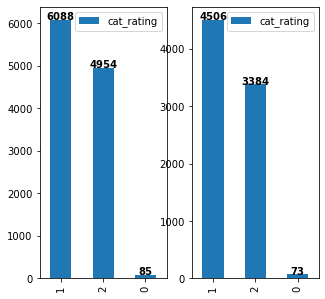

In [35]:
plt.subplot(1,2,1)
value_counts = df['cat_rating'].value_counts()
ax1 = value_counts.plot(kind='bar', figsize=(10, 10))
for i in ax1.patches:
    height = i.get_height()
    ax1.text(i.get_x() + i.get_width() / 2., height + 0.5, f'{height:.0f}', ha='center', fontweight='bold')
ax1.legend()

plt.subplot(1,2,2) 
ax2 = df_no_outliers['cat_rating'].value_counts().plot(kind='bar', figsize=(5, 5))
# Add percentage labels to each bar
for i in ax2.patches:
    height = i.get_height()
    ax2.text(i.get_x() + i.get_width() / 2., height + 0.5, f'{height:.0f}', ha='center', fontweight='bold')
ax2.legend()

plt.show()

###  Data scaling
We applied a scaling of our data in order to improve our model but that wasn't the case. 
We leave that scaling step apart
As we observed outliers, we decided to use RobustScaler()

In [41]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train, y_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)
X_test_scaled_df.describe()

,num_pages,ratings_count,text_reviews_count,publication_month,publication_year,language_cat,author_total_book,author_cat,text_review_rate,title_len
count,3339.000000,3339.000000,3339.000000,3339.000000,3339.000000,3339.000000,3339.000000,3339.000000,3339.000000,3339.000000
mean,0.154414,3.385436,2.111949,-0.101288,-0.379412,0.053609,0.495467,0.013736,0.210026,0.170472
std,1.035408,19.945870,10.054222,0.687391,1.182520,0.225278,1.295607,0.598114,1.063431,0.823253
min,-1.339286,-0.148882,-0.197479,-1.200000,-14.714286,0.000000,-0.363636,-1.006661,-0.881154,-0.965517
25%,-0.468750,-0.129915,-0.163866,-0.600000,-0.714286,0.000000,-0.272727,-0.483226,-0.441220,-0.448276
50%,-0.013393,-0.007625,-0.012605,-0.200000,0.000000,0.000000,0.000000,-0.013080,-0.037515,0.000000
75%,0.517857,0.773102,0.693277,0.600000,0.285714,0.000000,0.772727,0.533366,0.554602,0.551724
max,12.142857,460.935805,237.634454,1.000000,2.285714,1.000000,7.545455,1.036696,13.217310,6.172414
